Updated October 26. Designs probes against entire tandem arrays. Uses the sequence with UTRs but without introns. Blasts against transcriptome with introns, transcriptome without introns, and intergenic databases to verify specificity. 
Author: Giacomo Glotzer. 

In [1]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import subprocess
import sys
sys.path.append('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/analysis')
from transcriptomics import * 
from hcr import *
from plotting import * 

# Specify blast databases
new_transcriptome_db_no_introns = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/mRNA_no_introns/mRNA_no_introns"
new_transcriptome_db_yes_introns = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/mRNA_yes_introns/mRNA_yes_introns"
all_intergenic_regions_db = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/intergenics/all_intergenic_regions"

# Load genome
genome_fasta_path = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/OR List.xlsx') 

Initializing transcriptomics package
Initializing HCR package
Initializing plotting package


In [2]:
# set main directory for writing files 
main_directory = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/whole_tandem_array_probe_design/'

In [3]:
# Specify TA 
TA = 79

In [4]:
# Get genes 
genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values

# Remove fragments
genes = [gene for gene in genes if 'frag' not in gene]

# Get gene objects from tr 
gene_objects = [tr.get_gene(gene) for gene in genes]

# Print the number of genes 
print("Number of genes: ", len(gene_objects))

Number of genes:  11


In [5]:
# Get chromosome 
chromosome = gene_objects[0].chromosome
chromosome

'Chr1'

In [6]:
# Export each gene sequence to a fasta file 
output_dir = os.path.join(main_directory, 'or_seq_blast_input')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

for gene in gene_objects: 
    # Here we use only the EXONS and UTRs, NO INTRONS 
    sequence = gene.get_transcript_longest_cds().mrna_sequence
    with open(f"{output_dir}/{gene.name}.fasta", 'w') as f: 
        f.write(f">{gene.name}\n{sequence}")

print(f"Exported {len(gene_objects)} gene sequences to {output_dir}")

Exported 11 gene sequences to /Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/whole_tandem_array_probe_design/or_seq_blast_input


In [7]:
## Blast genes against the transcriptome without introns (mature mRNA), transcriptome with introns (pre-mRNA), and intergenic regions 
input_dir = os.path.join(main_directory, 'or_seq_blast_input')
output_dir = os.path.join(main_directory, 'or_seq_blast_output')

# create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")
    
# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

for gene in gene_objects:
    input_path = f"{input_dir}/{gene.name}.fasta"
    # no introns 
    output_path = f"{output_dir}/{gene.name}_blasted_no_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_no_introns} -ungapped -word_size 15 -reward 1 -penalty -5 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)
    # yes introns
    output_path = f"{output_dir}/{gene.name}_blasted_yes_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_yes_introns} -ungapped -word_size 15 -reward 1 -penalty -5 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)
    # intergenic 
    output_path = f"{output_dir}/{gene.name}_blasted_intergenics.csv"
    command = f"blastn -task blastn -query {input_path} -db {all_intergenic_regions_db} -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

In [8]:
length_thresh = 50 

## Iterate through blast results and annotate non-unique regions 
input_dir = os.path.join(main_directory, 'or_seq_blast_output')
output_dir = os.path.join(main_directory, 'or_seq_unique_regions') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

for gene in gene_objects:
    # No introns
    input_path = f"{input_dir}/{gene.name}_blasted_no_introns.csv"
    blast_results_no_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results_no_introns['source'] = 'no_introns'

    # Yes introns
    input_path = f"{input_dir}/{gene.name}_blasted_yes_introns.csv"
    blast_results_yes_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results_yes_introns['source'] = 'yes_introns'

    # Yes introns
    input_path = f"{input_dir}/{gene.name}_blasted_intergenics.csv"
    blast_results_intergenics = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results_intergenics['source'] = 'intergenics'

    # Concatenate 
    blast_results = pd.concat([blast_results_no_introns, blast_results_yes_introns, blast_results_intergenics], axis=0)

    # Add column for subject gene ID 
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: tr.get_gene_from_transcript(x['subject_acc']), axis=1)
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: x['subject_gene_id'] if x['subject_gene_id'] != None else tr.get_gene_from_transcript(x['subject_id']), axis=1)

    # Add column for tandem array using or_db or nan in case of non-OR gene
    blast_results['tandem_array'] = blast_results['subject_gene_id'].apply(
        lambda x: or_db[or_db['gene_name'] == x]['tandem_array'].values[0] 
        if x in or_db['gene_name'].values 
        else ""
    )

    # Add column for whether the query and subject gene are the same
    blast_results['same_gene'] = blast_results['query_id'] == blast_results['subject_gene_id']

    # Add column for whether the query and subject gene are in the same TA
    # note that any hits to intergenic regions will also be marked as False
    blast_results['same_TA'] = blast_results['tandem_array'] == TA

    # Here we use only the EXONS and UTRs, NO INTRONS 
    sequence = gene.get_transcript_longest_cds().mrna_sequence

    # Get off-targets
    off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                        (blast_results['same_TA'] == False), :] # Find off-targets that are not in the same TA

    # Annotate off-targets 
    for j, row in off_targets.iterrows():
        sequence = sequence[:row['q_start']] + '-'*(row['q_end'] - row['q_start']) + sequence[row['q_end']:]

    # Save the annotated sequence to the gene object
    gene.unique_sequence = sequence 

    # Save the blast results to the gene object 
    gene.blast_results = blast_results

    # Save the sequence to new file 
    with open(f"{output_dir}/{gene.name}_unique.fasta", 'w') as f:
        f.write(f">{gene.name}\n")
        f.write(sequence)

print(f"Unique regions have been annotated and exported to {output_dir}")

Unique regions have been annotated and exported to /Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/whole_tandem_array_probe_design/or_seq_unique_regions


In [9]:
gene_objects[0].blast_results

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,source,subject_gene_id,tandem_array,same_gene,same_TA
0,Or5-9E4,gnl|WGS:QOIP|geneOr5-9E4-RA,WGS:QOIP:geneOr5-9E4-RA,100.0,1783,0,0,1,1783,1,1783,0.000000e+00,3564.0,no_introns,Or5-9E4,79,True,True
1,Or5-9E4,gnl|WGS:QOIP|geneOr5-9E3PSE-RA,WGS:QOIP:geneOr5-9E3PSE-RA,100.0,342,0,0,13,354,1,342,0.000000e+00,684.0,no_introns,Or5-9E3PSE,,False,False
2,Or5-9E4,gnl|WGS:QOIP|geneOr5-9E3PSE-RA,WGS:QOIP:geneOr5-9E3PSE-RA,100.0,282,0,0,726,1007,720,1001,2.630000e-159,564.0,no_introns,Or5-9E3PSE,,False,False
3,Or5-9E4,gnl|WGS:QOIP|geneOr5-9E3PSE-RA,WGS:QOIP:geneOr5-9E3PSE-RA,100.0,241,0,0,470,710,467,707,1.230000e-134,482.0,no_introns,Or5-9E3PSE,,False,False
4,Or5-9E4,gnl|WGS:QOIP|geneOr5-9E3PSE-RA,WGS:QOIP:geneOr5-9E3PSE-RA,100.0,181,0,0,1017,1197,1011,1191,1.570000e-98,362.0,no_introns,Or5-9E3PSE,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,Or5-9E4,T17-Or5-9E333-Or5-9E334-Chr10:13085040-13085399,T17-Or5-9E333-Or5-9E334-Chr10:13085040-13085399,100.0,15,0,0,1537,1551,296,310,9.400000e-01,30.4,intergenics,None,,False,False
48,Or5-9E4,T17-Or5-9E330-Or5-9E331-Chr10:13066602-13068613,T17-Or5-9E330-Or5-9E331-Chr10:13066602-13068613,100.0,15,0,0,1537,1551,1625,1639,9.400000e-01,30.4,intergenics,None,,False,False
49,Or5-9E4,T17-Or5-9E311-Or5-9E312-Chr10:12975532-12976484,T17-Or5-9E311-Or5-9E312-Chr10:12975532-12976484,100.0,15,0,0,713,727,600,614,9.400000e-01,30.4,intergenics,None,,False,False
50,Or5-9E4,T17-Or5-9E279-Or5-9E280-Chr10:12824760-12825410,T17-Or5-9E279-Or5-9E280-Chr10:12824760-12825410,100.0,15,0,0,1638,1652,32,46,9.400000e-01,30.4,intergenics,None,,False,False


In [10]:
# Determine how many probes fit on each gene 
for gene in gene_objects: 
    sequence = gene.unique_sequence 
    probes, regions, positions = design_hcr_probes(sequence, "B1")
    gene.num_available_probes = len(probes)

num_probes = pd.DataFrame({'gene': [gene.name for gene in gene_objects], 'num_available_probes': [gene.num_available_probes for gene in gene_objects]})
num_probes

,gene,num_available_probes
0,Or5-9E4,5
1,Or5-9E5,12
2,Or5-9E6,8
3,Or5-9E7,2
4,Or5-9E8,18
5,Or5-9E9,10
6,Or5-9E10,10
7,Or5-9E11,5
8,Or5-9E12,14
9,Or5-9E13,6


In [11]:
# Specify amplifier 
amplifier = "B1"

In [12]:
# Specify how many probes per gene 
n_probes_per_gene = 7

In [13]:
# Export excel sheet with probes and excel sheet with probe binding regions 
all_probes = []
all_regions = []
for gene in gene_objects: 
    sequence = gene.unique_sequence 

    # Design probes
    probes, regions, positions = design_hcr_probes(sequence, amplifier)

    # Randomly select n_probes_per_gene probes 
    np.random.seed(0)
    if len(probes) < n_probes_per_gene:
        indices = range(len(probes))
    else: 
        indices = np.random.choice(range(len(probes)), n_probes_per_gene, replace=False)
    probes = [probes[i] for i in indices]
    regions = [regions[i] for i in indices]

    # Save probes and regions to gene object
    gene.probes = probes
    gene.regions = regions

    # Append to all_probes and all_regions
    all_probes.extend([probe for sublist in probes for probe in sublist])
    all_regions.extend(regions)

# Get date 
today = pd.Timestamp.now().strftime('%Y-%m-%d')

# Export probes 
output_dir = os.path.join(main_directory, 'IDT_sheets')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Create output path
output_path = f"{output_dir}/T{TA}-{amplifier}-{today}.xlsx"
df = pd.DataFrame({'Sequence': all_probes})
df['Pool name'] = f'T{TA}-{amplifier}'
df = df[['Pool name', 'Sequence']]
df.to_excel(output_path, index=False)
print(f"{len(all_probes)} probes have been exported to {output_path}")


# Export probe binding regions
output_dir = os.path.join(main_directory, 'probe_binding_regions_sheets') 
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Create output path
output_path = f"{output_dir}/T{TA}-{amplifier}-regions-{today}.xlsx"
# Make a vector of the gene names for each probe 
target_genes = [gene.name for gene in gene_objects for _ in range(len(gene.probes))]
probes_1 = [probe[0] for gene in gene_objects for probe in gene.probes]
probes_2 = [probe[1] for gene in gene_objects for probe in gene.probes]
df = pd.DataFrame({'Gene': target_genes, 
                   'Region': all_regions, 
                   'Probe 1': probes_1, 
                   'Probe 2': probes_2})
df.to_excel(output_path, index=False)

128 probes have been exported to /Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/whole_tandem_array_probe_design/IDT_sheets/T79-B1-2024-11-09.xlsx


In [14]:
# Export all_regions to individual fasta files 

output_dir = os.path.join(main_directory, 'probe_region_blast_input')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Export all_regions to individual fasta files in output_dir 
for i, region in enumerate(all_regions): 
    with open(f"{output_dir}/region-{i}.fasta", 'w') as f: 
        f.write(f">region-{i}\n{region}")

In [15]:
# Blast all regions against the transcriptome

input_dir = os.path.join(main_directory, 'probe_region_blast_input')
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Blast each region against the transcriptome
for i, region in enumerate(all_regions): 
    input_path = f"{input_dir}/region-{i}.fasta"

    # Blast against transcriptome without introns
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_no_introns} -ungapped -word_size 15 -reward 1 -penalty -1 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against transcriptome with introns
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_yes_introns} -ungapped -word_size 15 -reward 1 -penalty -1 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against intergenics 
    output_path = f"{output_dir}/region-{i}-blasted_intergenics.csv"
    command = f"blastn -task blastn -query {input_path} -db {all_intergenic_regions_db} -ungapped -word_size 15 -reward 1 -penalty -1 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

print("All regions have been blasted")

All regions have been blasted


In [16]:
# Load in blast results
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 
all_blast_results = []
for i, region in enumerate(regions):
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'no_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'yes_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_intergenics.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'intergenics'
    all_blast_results.append(blast_results)

In [17]:
# Check for non-unique regions

num_hits_over_thresh = 0
length_thresh = 50
mismatch_thresh = 5 
all_off_targets = pd.DataFrame()

# Iterate through blast results 
for i, blast_results in enumerate(all_blast_results):
    if len(blast_results) == 0: 
        continue

    # Add column for subject gene ID 
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: tr.get_gene_from_transcript(x['subject_acc']), axis=1)
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: x['subject_gene_id'] if x['subject_gene_id'] != None else tr.get_gene_from_transcript(x['subject_id']), axis=1)

    # Add column for tandem array using or_db or nan in case of non-OR gene
    blast_results['tandem_array'] = blast_results['subject_gene_id'].apply(
        lambda x: or_db[or_db['gene_name'] == x]['tandem_array'].values[0] 
        if x in or_db['gene_name'].values 
        else ""
    )

    # Add column for whether the query and subject gene are in the same TA
    blast_results['same_TA'] = blast_results['tandem_array'] == TA

    # Get off-targets
    off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                    (blast_results['mismatches'].values <= mismatch_thresh) & # mismatch threshold
                                    (blast_results['same_TA'] == False), :] # off-targets only 

    # Add to the all_off_targets dataframe
    all_off_targets = pd.concat([all_off_targets, off_targets])

    # Update num_hits_over_thresh   
    num_hits_over_thresh += len(off_targets)

print(f"Found {num_hits_over_thresh} off-target hits with length >= {length_thresh}bp, mismatches <= {mismatch_thresh}")

Found 0 off-target hits with length >= 50bp, mismatches <= 5


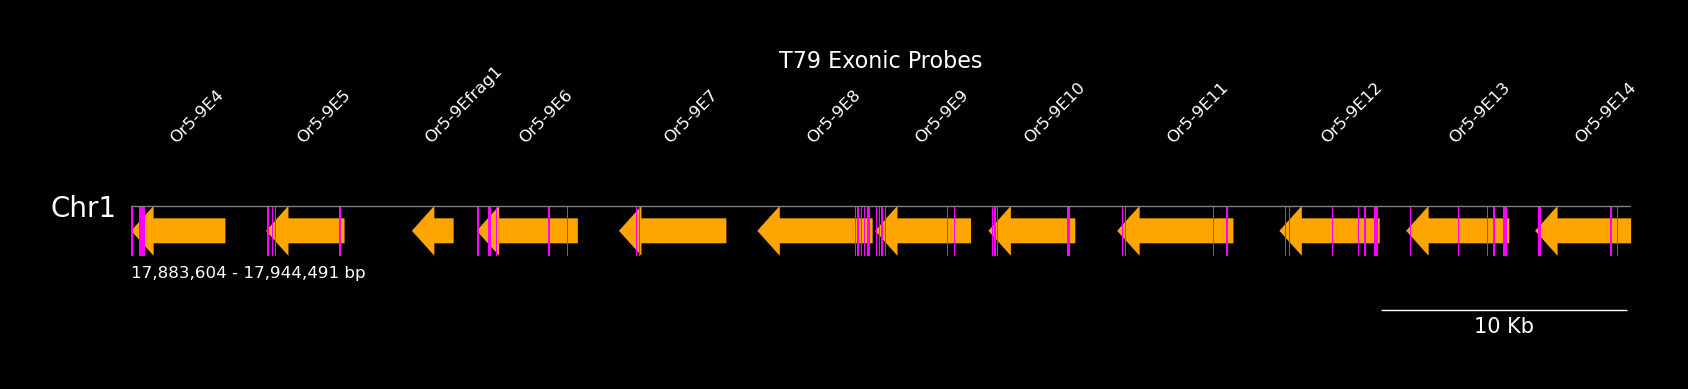

In [19]:
# Create a new GenomeViz object
black_plotting()
gv = GenomeViz(track_align_type="center", theme="dark")
gv.set_scale_bar(ymargin=0.5)

# Get genes 
genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values
# Get gene objects from tr 
gene_objects = [tr.get_gene(gene) for gene in genes]

# Get bounds 
chromosome = gene_objects[0].chromosome
bounds = [gene_object.get_transcript_longest_bounds().get_bounds() for gene_object in gene_objects]
min_start = int(np.min(bounds))
max_end = int(np.max(bounds))
track = gv.add_feature_track(chromosome, segments = (min_start, max_end))
track.add_sublabel()

# Add gene models to plot 
for gene in gene_objects:
    transcript = gene.get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    track.add_feature(int(bounds[0]), int(bounds[1]), strand, plotstyle='arrow', arrow_shaft_ratio = 0.5, label=gene.name)

# Get the region of the genome 
forward_seq = str(genome_seq[chromosome].seq[min_start:max_end]).upper()

# Add probe regions to plot on opposite strand 
for region in all_regions:
    positions = [m.start() for m in re.finditer(region, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + len(region), 1, plotstyle="box", label = '', ec="none", fc="magenta", alpha=1)

# Add reverse complement 
reverse_seq = reverse_complement(forward_seq)
for region in all_regions:
    positions = [m.start() for m in re.finditer(region, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - len(region), max_end - position, -1, plotstyle="box", label = '', ec="none", fc="magenta", alpha=1)

fig = gv.plotfig()

plt.title(f"T{TA} Exonic Probes", y=1.8, fontsize=16)
plt.show()

# Export figure 
output_dir = os.path.join(main_directory, 'probe_regions_plot')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save figure
output_path = f"{output_dir}/T{TA}-{amplifier}-probes-{today}.png"
fig.savefig(output_path, bbox_inches='tight', dpi=300)

